# Introduction

The following notebook presents both the definition of the models to be used (including preprocessing and hyperparameter tuning) and their respective evaluation.

# 0. Import Libraries and Other Code

In [1]:
# Relevant Libraries

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

import seaborn as sns
import matplotlib.pyplot as plt

import os
import pickle

In [2]:
def EvaluateModelsOverDataset(Models:list[str],Dataset_X:pd.DataFrame,Dataset_y:pd.Series,TypeDataset:str) -> pd.DataFrame:
    Metrics = [accuracy_score,precision_score,recall_score,f1_score]
    Global_Variables = globals()
    
    evaluation_results = {}
    for model_name in Models:
        y_predictions = Global_Variables[f'Best_{model_name}'].predict(Dataset_X)
        evaluation_results[f'{model_name}'] = [metric(Dataset_y,y_predictions) for metric in Metrics]

    EvaluationsResults = pd.DataFrame(evaluation_results)
    EvaluationsResults.rename(index={0:'Accuracy',1:'Precision',2:'Recall',3:'F1'},inplace=True)

    fig , axes = plt.subplots()
    axes.set_title(f'Results of Model Evaluations\nover {TypeDataset} Set',size=18)
    EvaluationsResults.plot(kind='bar',rot=0,ax=axes,legend=False)

    axes.set_ylabel('Score',size=14)
    axes.set_xlabel('Metric',size=14)
    axes.tick_params(labelsize=12)
    axes.set_ylim(0,1)

    fig.legend(bbox_to_anchor=(1.1,0.6))

    return EvaluationsResults

# 1. Load and Split Dataset

In [3]:
# Loading dataset

PlantGrowth_Dataset = pd.read_csv("../Datasets/plant_growth_data.csv")

# Splitting variables into Numerical and Categorical Features and Target

labels_variables = PlantGrowth_Dataset.columns

Features = labels_variables[:-1]
Target = labels_variables[-1]

NumericalFeatures , CategoricalFeatures = [] , []
for feature in Features:
    if PlantGrowth_Dataset[feature].dtype == 'object':
        CategoricalFeatures.append(feature)
    else:
        NumericalFeatures.append(feature)

In [4]:
# Splitting dataset

RANDOM_STATE = 8013

X_train , X_test , y_train , y_test = train_test_split(PlantGrowth_Dataset[Features],PlantGrowth_Dataset[Target],test_size=0.25,random_state=RANDOM_STATE)

In [5]:
# Defining number of threads or n_jobs 

THREADS = int(np.sqrt(os.cpu_count()))

# 2. Preprocessing Pipeline

As it could be observed in the EDA of the dataset, the numerical features are not separated or distinguished according to the significant growth reported, therefore it is proposed to generate features that are obtained from them in a simple way, that is, by applying non-linear functions such as: ``sqrt``, ``log10``, ``1/x`` and ``x**2``, together with the identity function. In order to promote other types of interactions or relationships.

In the case of the categorical features, since the only relevant feature is ``Fertilizer_Type`` and the other two seem to be independent for predicting the type of growth, they are kept in case of possible interactions with the other numerical features.

After generating the different features, it can be concluded that the attribute space is large, this is negative for the training of the model, since it increases the computational cost and possible redundancies; therefore, to reduce this impact, attribute selection is used. For numerical features, it is used mutual information (to be able to capture non-linear relationships and interactions), and for categorical features, it is used $\chi^2$ (to consider features that are not independent with respect to ``Growth_Milestone``).

In [6]:
# Importing additional estimators

from sklearn.preprocessing import OneHotEncoder , StandardScaler , FunctionTransformer
from sklearn.feature_selection import SelectKBest , mutual_info_classif , chi2

In [7]:
# Defining Numerical Preprocessing

def _identity(x):
    return x
def _inverse(x):
    return 1/x
def _square(x):
    return x*x
extras_numerical_features = FeatureUnion(
    [
        ('x',FunctionTransformer(_identity)),
        ('1/x',FunctionTransformer(_inverse)),
        ('x**2',FunctionTransformer(_square)),
        ('sqrt',FunctionTransformer(np.sqrt)),
        ('log10',FunctionTransformer(np.log10)),
    ]
)

numerical_preprocessing = Pipeline(
    [
        ('ExtraFeatures',extras_numerical_features),
        ('Standardization',StandardScaler()),
        ('FeatureSelection',SelectKBest(mutual_info_classif,k=10)),
    ]
)

In [8]:
# Defining Categorical Preprocessing

categorical_preprocessing = Pipeline(
    [
        ('Encode',OneHotEncoder()),
        ('FeatureSelection',SelectKBest(chi2,k=6)),
    ]
)

In [9]:
# Defining Features Preprocessing

Features_Preprocessing = ColumnTransformer(
    [
        ('CategoricalFeatures',categorical_preprocessing,CategoricalFeatures),
        ('NumericalFeatures',numerical_preprocessing,NumericalFeatures),
    ]
)

In [10]:
# Defining Preprocessing Pipeline

Preprocessing_Pipeline = Pipeline(
    [
        ('FeaturesPreprocessing',Features_Preprocessing),
    ]
)

Preprocessing_Pipeline

Pipeline(steps=[('FeaturesPreprocessing',
                 ColumnTransformer(transformers=[('CategoricalFeatures',
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder()),
                                                                  ('FeatureSelection',
                                                                   SelectKBest(k=6,
                                                                               score_func=<function chi2 at 0x000001E96ACDF740>))]),
                                                  ['Soil_Type',
                                                   'Water_Frequency',
                                                   'Fertilizer_Type']),
                                                 ('NumericalFeatures',
                                                  Pipeline(steps=[('ExtraFeatures',
                                                                   FeatureUnion(transfo...
                                                                                                   FunctionTransformer(func=<function _square at 0x000001E96ACF8D60>)),
                                                                                                  ('sqrt',
                                                                                                   FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                  ('log10',
                                                                                                   FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                  ('Standardization',
                                                                   StandardScaler()),
                                                                  ('FeatureSelection',
                                                                   SelectKBest(score_func=<function mutual_info_classif at 0x000001E96ACDD6C0>))]),
                                                  ['Sunlight_Hours',
                                                   'Temperature',
                                                   'Humidity'])]))])

# 3. Model Architectures

Due to what can be seen in the EDA, the classes for the significant growth type are not linearly separable, that is, they do not have decision edges that arise from linear functions; therefore, it is necessary to generate this separation by means of models that use or create nonlinear decision edges. Therefore, it is considered to use models based on Support Vector Machine, Random Forest, Adaptive Boost (AdaBoost) and XGBoost (Gradiente Boosting) [[1]](#references) to define the classifier.

For contrasting with models that make use of linear functions and similarity or closeness mechanisms, models based on Logistic Regression and K-Nearest Neighbors (KNN) [[1]](#references) are used. These models are expected to behave similarly to the previous ones because they allow capturing other types of relationships between instances or variables.

In [11]:
# Importing models

from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from skopt.space import Integer , Real , Categorical

In [12]:
# Model Architectures 

Model_Architectures = ['SVM','Forest','AdaBoost','Logistic','KNN']

## 3.1 Support Vector Machine

In [13]:
# SVM model

Model_SVM = Pipeline(
    [
        ('Preprocessing',Preprocessing_Pipeline),
        ('Classifier',SVC(random_state=RANDOM_STATE)),
    ]
)

c_parameters = Real(1e-10,5)
gamma = Real(0,4)
Parameters_SVM = [
    {
        'Classifier__kernel' : ['poly'],
        'Classifier__C' : c_parameters,
        'Classifier__gamma' : gamma,
        'Classifier__degree' : Integer(1,4),
        'Classifier__coef0' : Real(0,2),
    },
    {
        'Classifier__kernel' : Categorical(['rbf','sigmoid']),
        'Classifier__C' : c_parameters,
        'Classifier__gamma' : gamma,
    },
]

Model_SVM

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('FeaturesPreprocessing',
                                  ColumnTransformer(transformers=[('CategoricalFeatures',
                                                                   Pipeline(steps=[('Encode',
                                                                                    OneHotEncoder()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=6,
                                                                                                score_func=<function chi2 at 0x000001E96ACDF740>))]),
                                                                   ['Soil_Type',
                                                                    'Water_Frequency',
                                                                    'Fertilizer_Type']),
                                                                  ('NumericalFeatures',
                                                                   Pipeline(steps=[('Ex...
                                                                                                                    FunctionTransformer(func=<function _square at 0x000001E96ACF8D60>)),
                                                                                                                   ('sqrt',
                                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                                   ('log10',
                                                                                                                    FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                                   ('Standardization',
                                                                                    StandardScaler()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(score_func=<function mutual_info_classif at 0x000001E96ACDD6C0>))]),
                                                                   ['Sunlight_Hours',
                                                                    'Temperature',
                                                                    'Humidity'])]))])),
                ('Classifier', SVC(random_state=8013))])

## 3.2 Random Forest

In [14]:
# Random Forest model

Model_Forest = Pipeline(
    [
        ('Preprocessing',Preprocessing_Pipeline),
        ('Classifier',RandomForestClassifier(random_state=RANDOM_STATE,n_jobs=THREADS)),
    ]
)

Parameters_Forest = {
    'Classifier__n_estimators' : Integer(1,100),
    'Classifier__criterion' : Categorical(['gini','entropy']),
    'Classifier__max_depth' : Integer(1,3),
    'Classifier__min_samples_split' : Real(1e-2,0.5),
}

Model_Forest

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('FeaturesPreprocessing',
                                  ColumnTransformer(transformers=[('CategoricalFeatures',
                                                                   Pipeline(steps=[('Encode',
                                                                                    OneHotEncoder()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=6,
                                                                                                score_func=<function chi2 at 0x000001E96ACDF740>))]),
                                                                   ['Soil_Type',
                                                                    'Water_Frequency',
                                                                    'Fertilizer_Type']),
                                                                  ('NumericalFeatures',
                                                                   Pipeline(steps=[('Ex...
                                                                                                                   ('sqrt',
                                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                                   ('log10',
                                                                                                                    FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                                   ('Standardization',
                                                                                    StandardScaler()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(score_func=<function mutual_info_classif at 0x000001E96ACDD6C0>))]),
                                                                   ['Sunlight_Hours',
                                                                    'Temperature',
                                                                    'Humidity'])]))])),
                ('Classifier',
                 RandomForestClassifier(n_jobs=4, random_state=8013))])

## 3.3 Adaptive Boosting

In [15]:
# AdaBoost model

Model_AdaBoost = Pipeline(
    [
        ('Preprocessing',Preprocessing_Pipeline),
        ('Classifier',AdaBoostClassifier(random_state=RANDOM_STATE)),
    ]
)

Parameters_AdaBoost = {
    'Classifier__estimator' : Categorical([DecisionTreeClassifier(max_depth=depth,random_state=RANDOM_STATE) for depth in range(1,5)]),
    'Classifier__n_estimators' : Integer(1,100),
    'Classifier__learning_rate' : Real(1e-3,2),
}

Model_AdaBoost

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('FeaturesPreprocessing',
                                  ColumnTransformer(transformers=[('CategoricalFeatures',
                                                                   Pipeline(steps=[('Encode',
                                                                                    OneHotEncoder()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=6,
                                                                                                score_func=<function chi2 at 0x000001E96ACDF740>))]),
                                                                   ['Soil_Type',
                                                                    'Water_Frequency',
                                                                    'Fertilizer_Type']),
                                                                  ('NumericalFeatures',
                                                                   Pipeline(steps=[('Ex...
                                                                                                                    FunctionTransformer(func=<function _square at 0x000001E96ACF8D60>)),
                                                                                                                   ('sqrt',
                                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                                   ('log10',
                                                                                                                    FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                                   ('Standardization',
                                                                                    StandardScaler()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(score_func=<function mutual_info_classif at 0x000001E96ACDD6C0>))]),
                                                                   ['Sunlight_Hours',
                                                                    'Temperature',
                                                                    'Humidity'])]))])),
                ('Classifier', AdaBoostClassifier(random_state=8013))])

## 3.4 Logistic Regression

In [16]:
# Logistic model

Model_Logistic = Pipeline(
    [
        ('Preprocessing',Preprocessing_Pipeline),
        ('Classifier',LogisticRegression(random_state=RANDOM_STATE,n_jobs=THREADS)),
    ]
)

Parameters_Logistic = {
    'Classifier__C' : Real(1e-10,5),
    'Classifier__penalty' : Categorical(['l1','l2']),
    'Classifier__solver' : Categorical(['liblinear','saga']),
}

Model_Logistic

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('FeaturesPreprocessing',
                                  ColumnTransformer(transformers=[('CategoricalFeatures',
                                                                   Pipeline(steps=[('Encode',
                                                                                    OneHotEncoder()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=6,
                                                                                                score_func=<function chi2 at 0x000001E96ACDF740>))]),
                                                                   ['Soil_Type',
                                                                    'Water_Frequency',
                                                                    'Fertilizer_Type']),
                                                                  ('NumericalFeatures',
                                                                   Pipeline(steps=[('Ex...
                                                                                                                   ('sqrt',
                                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                                   ('log10',
                                                                                                                    FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                                   ('Standardization',
                                                                                    StandardScaler()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(score_func=<function mutual_info_classif at 0x000001E96ACDD6C0>))]),
                                                                   ['Sunlight_Hours',
                                                                    'Temperature',
                                                                    'Humidity'])]))])),
                ('Classifier',
                 LogisticRegression(n_jobs=4, random_state=8013))])

## 3.5 K-Nearest Neighbors

In [17]:
# KNN model

Model_KNN = Pipeline(
    [
        ('Preprocessing',Preprocessing_Pipeline),
        ('Classifier',KNeighborsClassifier(n_jobs=THREADS)),
    ]
)

n_neighbors = Integer(3,50)
weights = Categorical(['uniform', 'distance'])
Parameters_KNN = [
    {
        'Classifier__n_neighbors' : n_neighbors,
        'Classifier__weights' : weights,
        'Classifier__p' : Integer(1,3),
    },   
    {
        'Classifier__n_neighbors' : n_neighbors,
        'Classifier__weights' : weights,
        'Classifier__metric' : Categorical(['cosine','correlation']),
    }
]

Model_KNN

Pipeline(steps=[('Preprocessing',
                 Pipeline(steps=[('FeaturesPreprocessing',
                                  ColumnTransformer(transformers=[('CategoricalFeatures',
                                                                   Pipeline(steps=[('Encode',
                                                                                    OneHotEncoder()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(k=6,
                                                                                                score_func=<function chi2 at 0x000001E96ACDF740>))]),
                                                                   ['Soil_Type',
                                                                    'Water_Frequency',
                                                                    'Fertilizer_Type']),
                                                                  ('NumericalFeatures',
                                                                   Pipeline(steps=[('Ex...
                                                                                                                    FunctionTransformer(func=<function _square at 0x000001E96ACF8D60>)),
                                                                                                                   ('sqrt',
                                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                                                                                   ('log10',
                                                                                                                    FunctionTransformer(func=<ufunc 'log10'>))])),
                                                                                   ('Standardization',
                                                                                    StandardScaler()),
                                                                                   ('FeatureSelection',
                                                                                    SelectKBest(score_func=<function mutual_info_classif at 0x000001E96ACDD6C0>))]),
                                                                   ['Sunlight_Hours',
                                                                    'Temperature',
                                                                    'Humidity'])]))])),
                ('Classifier', KNeighborsClassifier(n_jobs=4))])

# 4. Models Fine-Tunning

Since the classes in the dataset are balanced, it is possible to use the ``accuracy`` metric without the model creating simple decision rules or favoring a specific class. In this situation, this metric reduces the impact of false negatives and false positives, which translate as underestimating and overestimating the growth of a plant, respectively.

Therefore to perform the fine-tunning of the hyperparameters using ``Bayes Search``, making use of $6$ folds for the validation of the hyperparameters.

In [18]:
# Global variables
Global_Variables = globals()

In [ ]:
# Fine-Tunning using Bayes Cross-Validation

folds_k = 6
iterations = 20

for model_name in Model_Architectures:
    print(f'START OPTIMIZATION OF :: {model_name}')
    estimator_model = Global_Variables[f'Model_{model_name}']
    parameters_model = Global_Variables[f'Parameters_{model_name}']

    Global_Variables[f'Best_{model_name}'] = BayesSearchCV(estimator_model,parameters_model,scoring='accuracy',
                                                           cv=folds_k,n_iter=iterations,
                                                           n_jobs=THREADS,pre_dispatch='all',
                                                           random_state=RANDOM_STATE,
                                                           verbose=False,)
    Global_Variables[f'Best_{model_name}'].fit(X_train,y_train)

: 

In [ ]:
# Printing of best parameters for each model

for model_name in Model_Architectures:
    best_parameters = Global_Variables[f'Best_{model_name}'].best_params_
    print(f'Best found parameters of {model_name} are:\n{best_parameters}\n')

In [ ]:
# Save models (persistence)

Best_Models = [Global_Variables[f'Best_{model_name}'].best_estimator_ for model_name in Model_Architectures]
for model_name , model in zip(Model_Architectures,Best_Models):
        with open(f'model_{model_name}.pkl','wb') as model_file:
            pickle.dump(model,model_file,protocol=5)

In [ ]:
# # Load models 
# for model_name in Model_Architectures:
#         with open(f'model_{model_name}.pkl','rb') as model_file:
#             Global_Variables[f'Best_{model_name}'] = pickle.load(model_file)

# 5. Models Evaluation

The evaluation dataset is used to determine which model is the best in terms of ``precision``, this metric is used to avoid overestimating the growth of a plant, thus reducing the false positives predicted by the selected model. The remaining metrics (scores) of classification are used, which are evaluated in both the training and evaluation (test) sets to determine their bias-variance trade-off.

As a first filter it is considered the training metric, ``accuracy``, of the plots it can be seen how in the SVM, AdaBoost and Logistic Regression models behave the same and even better in both sets, so said, these models do not present overfit or underfit; In contrast with Random Forest and KNN that suffer from a notorious case of overfit, because their behavior is completely based on the training set, but when they are evaluated on the test set, the patterns learned in the training set are lost.

From the tabulated data it can be seen that the models passed the ``accuracy`` filter, have a better ``precision`` metric on the test set, except for AdaBoost, this means that these models did learn enough to be able to generalize the discovered patterns. 

,SVM,Forest,AdaBoost,Logistic,KNN
Accuracy,0.693878,0.612245,0.673469,0.714286,0.571429
Precision,0.629630,0.548387,0.615385,0.681818,0.516129
Recall,0.772727,0.772727,0.727273,0.681818,0.727273
F1,0.693878,0.641509,0.666667,0.681818,0.603774


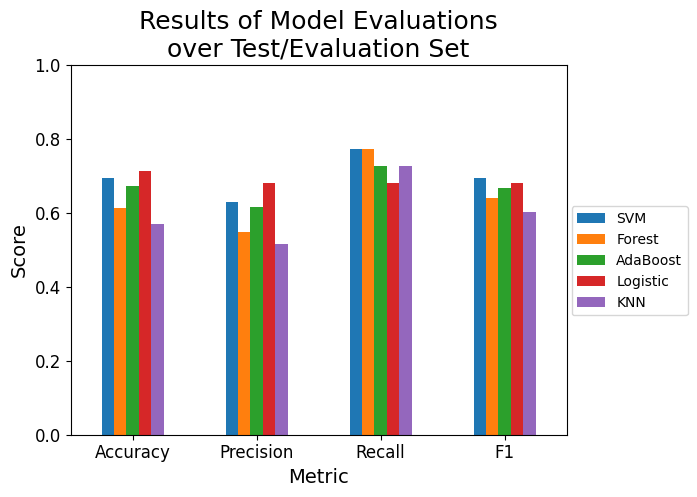

In [28]:
# Evaluating models over test set

EvaluateModelsOverDataset(Model_Architectures,X_test,y_test,'Test/Evaluation')

,SVM,Forest,AdaBoost,Logistic,KNN
Accuracy,0.638889,0.708333,0.694444,0.652778,1.0
Precision,0.619565,0.666667,0.659574,0.657895,1.0
Recall,0.770270,0.864865,0.837838,0.675676,1.0
F1,0.686747,0.752941,0.738095,0.666667,1.0


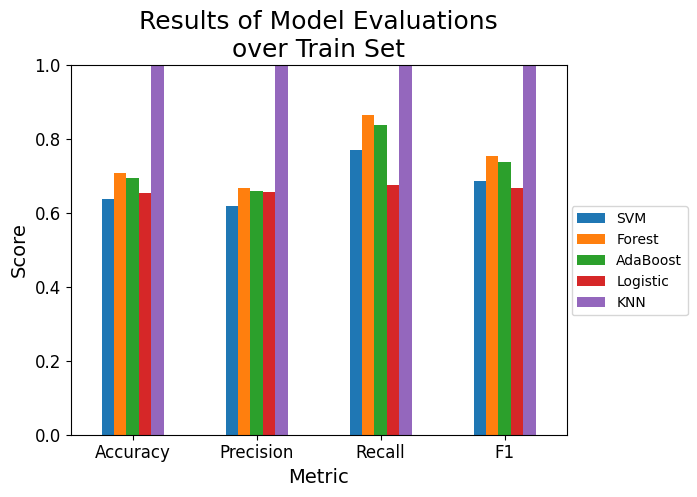

In [29]:
# Evaluating models over train set

EvaluateModelsOverDataset(Model_Architectures,X_train,y_train,'Train')

# 6. Model Selection

Of the six proposed models, the one that provides the best results is the Logistic Regression model, this could be because it captures in a better way the possible linear relationships between attributes that, apparently, are the most dominant; the latter allows this linear model to achieve the best scores in ``accuracy`` and ``precision``. Therefore, making the assumption that the variables are linearly related is a valuable and versatile assumption for this problem and, furthermore, does not generate major complications or discovery of more complex or nonlinear relationships that ignore the fundamental or more basic relationships. With this, it is concluded that the model to be put into production is the one based on linear models, Logistic Regression, including that it does not suffer from overfit or bias, leaving a robust model with high generalization capabilities.

# 7. Error Analysis

In [43]:
from re import sub

Color_Palette = ['lightgreen','darkgreen']

def GetFeatureName(Feature:str) -> str:
    """
        Function for getting feature's name 
        of a feature

        -- Feature : str :: Feature from which its name is obtained

        Return feature's name
    """
    return sub(r'_',' ',Feature)

def PlotDistributionsByTarget(Dataset:pd.DataFrame,Features:list[str],Target:str,TypePlot,FeatureTypeName:str,AdditionalPlotArgs:dict={}) -> None:
    """
        Function to plott distribution of features 
        by value of target

        -- Dataset : pd.DataFrame :: Dataset whose values are plotted

        -- Features : list[str] :: Attributes from which plots are generated

        -- Target : str :: Attribute that generates the hue in the plots

        -- TypePlot : Callable :: Type of plot generated

        -- FeatureTypeName : str :: Name given to the features

        -- AdditionalPlotArgs : dict :: Additional arguments to generate the plot

    """
    mosaic_grid = "1122\n.33."
    fig , axes = plt.subplot_mosaic(mosaic_grid,figsize=(8,6),layout='tight')

    for index_axes , feature in enumerate(Features,1):
        axes_plot = axes[str(index_axes)]
        TypePlot(Dataset,x=feature,hue=Target,palette=Color_Palette,ax=axes_plot,legend=False,**AdditionalPlotArgs)
        
        axes_plot.set_xlabel(GetFeatureName(feature),size=12)

    fig.suptitle(f'Distribution of\n{FeatureTypeName} Features',size=18)
    fig.legend(title='Growth Milestone',labels=['No Milestone','Milestone'],loc=(0.05,0.33))

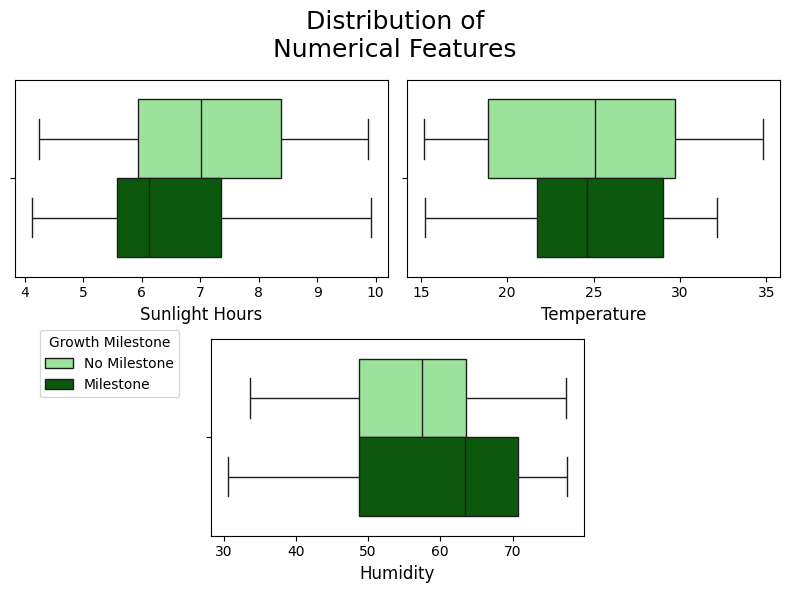

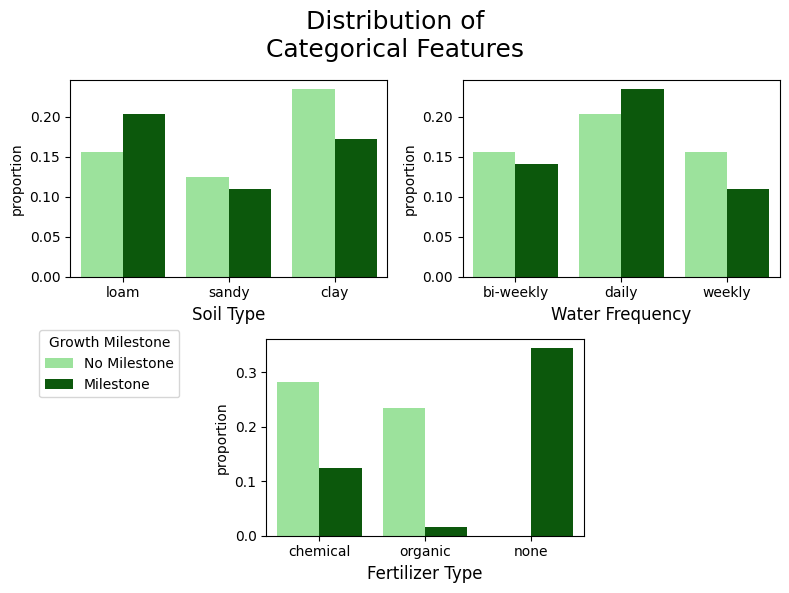

In [54]:
y_pred = Best_Logistic.predict(PlantGrowth_Dataset[Features])
Errors = PlantGrowth_Dataset[y_pred != PlantGrowth_Dataset[Target]]

PlotDistributionsByTarget(Errors,NumericalFeatures,Target,sns.boxplot,'Numerical')
PlotDistributionsByTarget(Errors,CategoricalFeatures,Target,sns.countplot,'Categorical',{'stat':'proportion'})

# References

* [1] API Reference. Scikit-learn developers. https://scikit-learn.org/stable/api/index.html